## Visualizing the stock market structure


This example employs several unsupervised learning techniques to extract
the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes
that are linked tend to cofluctuate during a day.

In [4]:
# Test DB Connection
from __future__ import print_function

import pandas as pd
import MySQLdb as mdb


def get_daily_price(ticker):
    # Connect to the MySQL instance
    db_host = 'localhost'
    db_user = 'sec_user'
    db_pass = 'password'
    db_name = 'securities_master'
    con = mdb.connect(db_host, db_user, db_pass, db_name)

    # Select all of the historic Google adjusted close data
    sql = """SELECT dp.price_date, dp.open_price, dp.close_price
             FROM symbol AS sym
             INNER JOIN daily_price AS dp
             ON dp.symbol_id = sym.id
             WHERE sym.ticker = 'GOOG'
             ORDER BY dp.price_date ASC;"""
    sql = sql.replace('GOOG', ticker)
    # Create a pandas dataframe from the SQL query
    df = pd.read_sql_query(sql, con=con, index_col='price_date')    

    return df

if __name__ == "__main__":
    print(get_daily_price('TSLA').tail())

            open_price  close_price
price_date                         
2018-08-02      328.44       349.54
2018-08-03      347.81       348.17
2018-08-06      345.46       341.99
2018-08-07      343.84       379.57
2018-08-08      369.09       370.34



Visualization
-------------

The output of the 3 models are combined in a 2D graph where nodes
represents the stocks and edges the:

- cluster labels are used to define the color of the nodes
- the sparse covariance model is used to display the strength of the edges
- the 2D embedding is used to position the nodes in the plan

This example has a fair amount of visualization-related code, as
visualization is crucial here to display the graph. One of the challenge
is to position the labels minimizing overlap. For this we use an
heuristic based on the direction of the nearest neighbor along each
axis.

Automatically created module for IPython interactive environment


Fetching quote history for 'AAPL'
Fetching quote history for 'AIG'
Fetching quote history for 'AMZN'
Fetching quote history for 'AXP'
Fetching quote history for 'BA'
Fetching quote history for 'BAC'
Fetching quote history for 'CAT'
Fetching quote history for 'CL'
Fetching quote history for 'CMCSA'
Fetching quote history for 'COP'
Fetching quote history for 'CSCO'
Fetching quote history for 'CVS'
Fetching quote history for 'CVX'
Fetching quote history for 'F'
Fetching quote history for 'GD'
Fetching quote history for 'GE'
Fetching quote history for 'GM'
Fetching quote history for 'GS'
Fetching quote history for 'HD'
Fetching quote history for 'HPQ'
Fetching quote history for 'IBM'
Fetching quote history for 'JPM'
Fetching quote history for 'K'
Fetching quote history for 'KMB'
Fetching quote history for 'KO'
Fetching quote history for 'MAR'
Fetching quote history for 'MCD'
Fetching quote history for 'MMM'
Fetching quote history for 'MSFT'
Fetching quote history for 'NOC'
Fetching quote h

Cluster 1: Colgate-Palmolive, Kellogg, Kimberly-Clark, Coca Cola, Pepsi, Procter Gamble, Wal-Mart
Cluster 2: Caterpillar, ConocoPhillips, Chevron, Exxon
Cluster 3: Ford, General Motors, Xerox
Cluster 4: AIG, American express, Bank of America, Comcast, Goldman Sachs, JPMorgan Chase, Valero Energy, Wells Fargo
Cluster 5: CVS, General Electrics, Home Depot, IBM, Marriott, McDonald's, 3M, Pfizer
Cluster 6: Boeing, General Dynamics, Northrop Grumman, Raytheon
Cluster 7: Tesla Inc
Cluster 8: Apple, Amazon, Cisco, HP, Microsoft, Nvidia, Texas Instruments


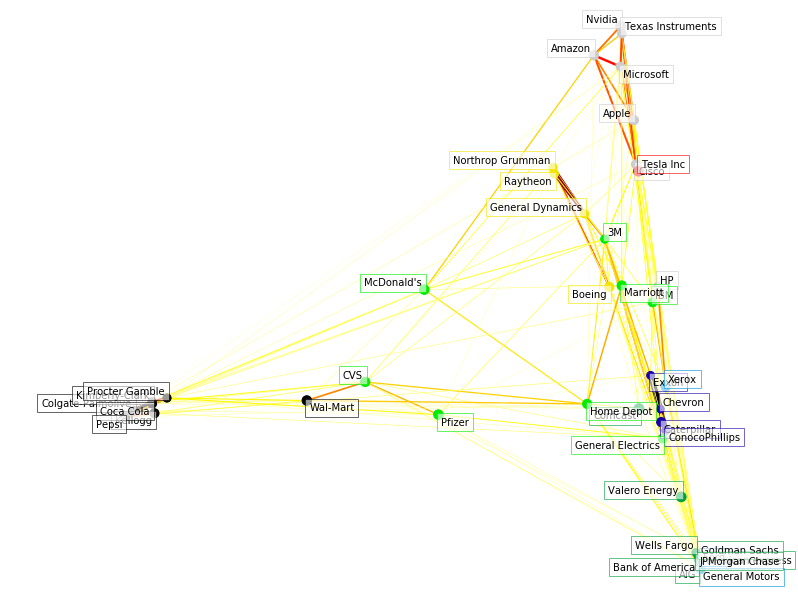

In [14]:
from __future__ import print_function

# Author: Gael Varoquaux gael.varoquaux@normalesup.org
# License: BSD 3 clause

import sys
from datetime import datetime
import csv

from sklearn.externals.six.moves.urllib.request import urlopen
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn import cluster, covariance, manifold

print(__doc__)


# #############################################################################
# Retrieve the data from Internet

# The data is from 2003 - 2008. This is reasonably calm: (not too long ago so
# that we get high-tech firms, and before the 2008 crash). This kind of
# historical data can be obtained for from APIs like the quandl.com and
# alphavantage.co ones.
start_date = datetime(2013, 1, 1).date()
end_date = datetime(2018, 1, 1).date()

symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'McDonald\'s',
    'PEP': 'Pepsi',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas Instruments',
    'XRX': 'Xerox',
    'WMT': 'Wal-Mart',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours',
    'TSLA':'Tesla Inc',
    'GM':'General Motors',
    'NVDA':'Nvidia'}

miss = ['CAJ', 'CVC', 'DD', 'DELL', 'GSK', 'HMC', 'NAV', 'NVS', 'R', 'SAP', 
        'SNE', 'SNY', 'TM', 'TOT', 'TWX', 'UN', 'YHOO']
for sym in miss:
    symbol_dict.pop(sym)
    
symbols, names = np.array(sorted(symbol_dict.items())).T
quotes = []

for symbol in symbols:
    print('Fetching quote history for %r' % symbol, file=sys.stderr)
    df = get_daily_price(symbol)
    df = df[df.index >= start_date.strftime("%Y-%m-%d")]
    df = df[df.index <= end_date.strftime("%Y-%m-%d")]
    quote = {'close': df['close_price'].tolist(),
             'open': df['open_price'].tolist()}
    
    quotes.append(quote)

    
close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices


# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

More Stocks 
-------------
Try to output more stocks like 500+ 

In [10]:
def get_all_symbols():
    # Connect to the MySQL instance
    db_host = 'localhost'
    db_user = 'sec_user'
    db_pass = 'password'
    db_name = 'securities_master'
    con = mdb.connect(db_host, db_user, db_pass, db_name)

    # Select all of the historic Google adjusted close data
    with con:
        cur = con.cursor()
        cur.execute("select distinct(ticker), name from symbol;")
        data = cur.fetchall()
        return {d[0]: d[1] for d in data}
    
symbol_dict = get_all_symbols()

C:\Users\lizhi\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: context interface will be changed.  Use explicit conn.commit() or conn.rollback().
  # Remove the CWD from sys.path while we load stuff.


Cluster 1: ABIOMED Inc
Cluster 2: Adobe Systems Inc, Autodesk Inc., Salesforce.com, Citrix Systems, Intuit, Microsoft Corp., Red Hat Inc.
Cluster 3: Archer-Daniels-Midland Co
Cluster 4: Alliance Data Systems
Cluster 5: AES Corp
Cluster 6: Allergan, Plc
Cluster 7: Akamai Technologies Inc
Cluster 8: Albemarle Corp
Cluster 9: Align Technology
Cluster 10: Advanced Micro Devices Inc, Nvidia Corporation
Cluster 11: American Tower Corp A, Crown Castle International Corp., SBA Communications
Cluster 12: ANSYS
Cluster 13: Aetna Inc, Anthem Inc., CIGNA Corp., Centene Corporation, Humana Inc., United Health Group Inc.
Cluster 14: Amphenol Corp, TE Connectivity Ltd.
Cluster 15: Arconic Inc.
Cluster 16: Activision Blizzard, Electronic Arts, Take-Two Interactive
Cluster 17: Apartment Investment & Management, AvalonBay Communities, Inc., Equity Residential, Essex Property Trust, Inc., Mid-America Apartments
Cluster 18: Avery Dennison Corp
Cluster 19: Advance Auto Parts, AutoZone Inc, O'Reilly Automot

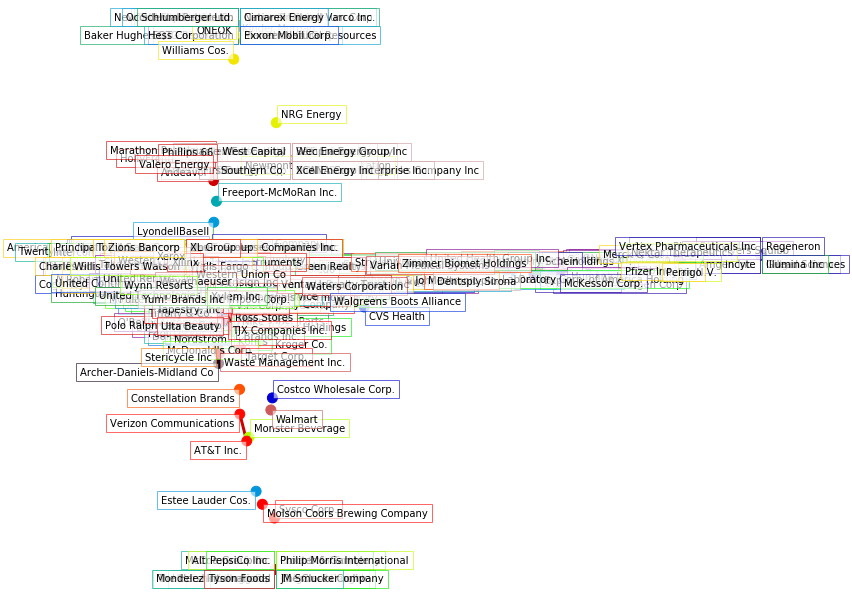

In [37]:
# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices


# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 *b embedding[1].ptp())

plt.show()